In [1]:
import tensorflow as tf

tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
import pathlib

data_root = pathlib.Path('C:/foto/age/categories_2500perclass_diffsz')

In [3]:
import random

all_image_paths = data_root.glob('*/*')
all_image_paths = map(str, all_image_paths)
all_image_paths = list(all_image_paths)
random.shuffle(all_image_paths)

len(all_image_paths), all_image_paths[:3]

(19181,
 ['C:\\foto\\age\\categories_2500perclass_diffsz\\from_49_to_60\\nm0750412_rm319797248_1960-11-17_2009.jpg',
  'C:\\foto\\age\\categories_2500perclass_diffsz\\from_13_to_18\\nm1440281_rm4005403392_1985-10-25_2003.jpg',
  'C:\\foto\\age\\categories_2500perclass_diffsz\\from_0_to_12\\nm1455681_rm3919088896_1993-12-8_2005.jpg'])

In [4]:
IMAGE_SIZE = 224
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)


def preprocess_image(image):
    image_tensor = tf.image.decode_jpeg(image, channels=3)
    image_tensor = tf.image.resize(image_tensor, IMAGE_SHAPE)
    image_tensor /= 255
    return image_tensor

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [312]:
import math


MAX_HUE_DELTA = 0.02
SATURATION_RANGE = (0.6, 1.4)
MAX_BRIGHTNESS_DELTA = 0.1
CONTRAST_RANGE = (0.4, 1.6)
SCALE_RANGE = (0.7, 1.0)
MAX_NOISE_VAR = 0.07
MAX_TRANSLATION = IMAGE_SIZE // 4
SALT_PEPPER_AMOUNT = 0.005 * IMAGE_SIZE * IMAGE_SIZE
SALT_FACTOR = 0.5
SALT_AMOUNT = int(SALT_FACTOR * SALT_PEPPER_AMOUNT)
PEPPER_AMOUNT = int((1 - SALT_FACTOR) * SALT_PEPPER_AMOUNT)
TRANSFORM_MAX_ANGLE_RAD = 0.2
MAX_ANGLE = 2 * math.pi
MAX_BLUR_FACTOR = 0.8


import numpy as np


def flip(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x

  
def color(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_hue(x, MAX_HUE_DELTA)
    x = tf.image.random_saturation(x, *(SATURATION_RANGE))
    x = tf.image.random_brightness(x, MAX_BRIGHTNESS_DELTA)
    x = tf.image.random_contrast(x, *(CONTRAST_RANGE))
    return x

  
def rotate(x: tf.Tensor) -> tf.Tensor:
    angles_shape = [] if len(x.shape) <= 3 else [x.shape[0]]
    angles = tf.random.uniform(angles_shape, 0, MAX_ANGLE, dtype=tf.float32)
    x = tf.contrib.image.rotate(
        x,
        angles,
        interpolation='NEAREST',
        name=None
    )
    return x

  
def zoom(x: tf.Tensor) -> tf.Tensor:
    scale = tf.random_uniform([], *(SCALE_RANGE), dtype=tf.float32)
    x1 = y1 = 0.5 - (0.5 * scale)
    x2 = y2 = 0.5 + (0.5 * scale)
    box = [x1, y1, x2, y2]
    
    crops = tf.image.crop_and_resize([x], boxes=[box], box_ind=[0], crop_size=IMAGE_SHAPE)
    
    return crops[0]


def to_grayscale(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.rgb_to_grayscale(x)
    x = tf.image.grayscale_to_rgb(x)
    return x


def translate(x: tf.Tensor) -> tf.Tensor:
    dx = tf.random_uniform([], 0, 2 * MAX_TRANSLATION, dtype=tf.int32) - MAX_TRANSLATION
    dy = tf.random_uniform([], 0, 2 * MAX_TRANSLATION, dtype=tf.int32) - MAX_TRANSLATION
    x = tf.contrib.image.translate(x, translations=[dx, dy])
    return x


def add_noise(x: tf.Tensor) -> tf.Tensor:
#     noise_var = np.random.uniform(0, MAX_NOISE_VAR)
#     gaussian = np.random.normal(0, noise_var, size=(IMAGE_SIZE, IMAGE_SIZE, 1))
    noise_var = tf.random_uniform([], 0, MAX_NOISE_VAR)
    gaussian = tf.random_normal([IMAGE_SIZE, IMAGE_SIZE, 1], 0, noise_var)
    x = x + gaussian
    return x


def add_salt_pepper_noise(x: tf.Tensor) -> tf.Tensor:
    pepper_coords = [np.random.randint(0, IMAGE_SIZE, PEPPER_AMOUNT) for _ in range(2)]
    peppered = np.ones(IMAGE_SHAPE + (3,))
    peppered[tuple(pepper_coords)] = 0
    x = x * peppered
    
    salt_coords = [np.random.randint(0, IMAGE_SIZE, SALT_AMOUNT) for _ in range(2)]
    salted = np.ones(IMAGE_SHAPE + (3,))
    salted[tuple(salt_coords)] = 0
    x = x * salted + (1 - salted)
    
    return x


def blur(x: tf.Tensor) -> tf.Tensor:
    blur_factor = np.random.uniform(0, MAX_BLUR_FACTOR)
    shape = ((1 - blur_factor) * np.array(IMAGE_SHAPE)).astype(int)
    tmp = tf.image.resize_images(
        [x],
        size=shape,
        method=tf.image.ResizeMethod.BICUBIC,
        align_corners=False,
        preserve_aspect_ratio=False
    )[0]
    x = tf.image.resize_images(
        [tmp],
        size=IMAGE_SHAPE,
        method=tf.image.ResizeMethod.BICUBIC,
        align_corners=False,
        preserve_aspect_ratio=False
    )[0]
    return x

In [313]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

AUG_AND_PROB = [
#     (flip, 0.25), 
#     (color, 0.25), 
#     (rotate, 0.25),
#     (zoom, 0.25), 
#     (to_grayscale, 0.1), 
#     (translate, 0.25), 
#     (add_noise, 1), 
#     (add_salt_pepper_noise, 0.25),
    (blur, 0.5)
]


def make_dataset(paths):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    
    for aug, prob in AUG_AND_PROB:
        image_ds = image_ds.map(
            lambda x: tf.cond(tf.random_uniform([], 0, 1) < prob, lambda: aug(x), lambda: x), 
            num_parallel_calls=AUTOTUNE
        )
    image_ds = image_ds.map(lambda x: tf.clip_by_value(x, 0, 1))
    
    return image_ds

In [314]:
import matplotlib.pyplot as plt


def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((IMAGE_SIZE * n_images, IMAGE_SIZE * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row * IMAGE_SIZE : (row + 1) * IMAGE_SIZE] = np.vstack(images.numpy())
        row += 1

    plt.figure(figsize=(20, 20))
    plt.imshow(output)
    figure = plt.gcf()
    return figure

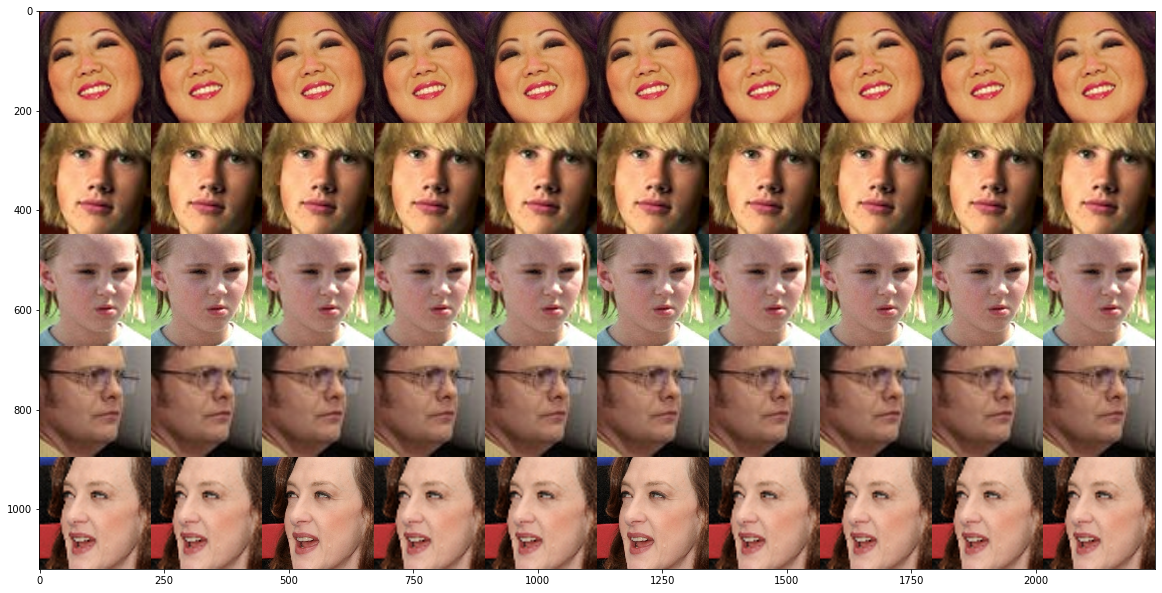

In [317]:
n_images = 5
image_ds = make_dataset(all_image_paths[:n_images])
figure = plot_images(image_ds, n_images=n_images, samples_per_image=10)
# figure.savefig('test_figure')

In [ ]:
figure.show()